In [1]:
import numpy as np
import os
import cv2
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.layers import Input, Embedding, Dense, Dropout, Flatten
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
import imutils
%matplotlib inline
import math
import matplotlib.pyplot
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot
image_size1 = 85
image_size2 = 128
from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import cross_val_score
from keras import backend as K
K.set_image_dim_ordering('th')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def load_train(simul):
    X_train = []
    y_train = []
    train_ds = pd.read_csv('Train.csv')
    print('Read train images')
    for index, row in train_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.transpose((2,0,1))
        X_train.append(img)
        if simul == 0:
            y_train.append(row['Competency_Score'])
        elif simul == 1:
            y_train.append(row['Trustworthy_Score'])
        else:    
            y_train.append([row['Competency_Score'],row['Trustworthy_Score']])         
    return X_train, y_train  

def read_and_normalize_train_data(simul,k= 3):
    train_data, train_target = load_train(simul)       
    train_data = np.array(train_data, dtype=np.float32)
    train_target = np.array(train_target, dtype=np.float32)
    print("Train data shape",train_data.shape)
    print("Train target shape",train_target.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target

# Image generators
def imagegen(config):
    if config == 1:
        datagen = ImageDataGenerator(
        rotation_range=120,
        zoom_range=0.40,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255,
        validation_split = 0.9)
    elif config == 2:
        datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=120,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255,
        validation_split = 0.9)
    elif config ==3:
        datagen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         rescale=1./255,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10)
    return datagen 

def create_model(config,output):
    if config == 1:
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(16, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Conv2D(32, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Conv2D(64, 3,activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x) 
        x = Flatten()(x)     
        x = Dense(500, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation='relu')(x)
        x = Dropout(0.25)(x)
        x = Dense(20, activation='relu')(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae'])
        return model
    elif config == 2: 
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(32, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Flatten()(x)     
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae'])
        return model
    elif config == 3:
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(32, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)       
#         x = BatchNormalization(axis= 3)  
        x = Conv2D(64, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)        
#         x = BatchNormalization(axis= 3)    
        x = Conv2D(128, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)        
#         x = BatchNormalization(axis = 3)(x)
        x = Conv2D(64, 3, activation='relu')(x)
        x = GlobalAveragePooling2D()(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae'])
        
        return model
def get_callbacks(name_weights, patience_lr,patience_es):
    mcp_save = ModelCheckpoint(name_weights,verbose=1,save_best_only=True, monitor='val_loss', mode='min')
    earlystopping = EarlyStopping(monitor='val_loss',patience=patience_es, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss,earlystopping]

# Simultaneous Regression

In [3]:
x,y = read_and_normalize_train_data(simul = None)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = create_model(config = 3,output = 2)
for j, (train_idx, val_idx) in enumerate(kfold.split(x,y)): 
    batch_size=50
    print('\nFold ',j)
    X_train_cv = x[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = x[val_idx]
    y_valid_cv= y[val_idx] 
    STEP_SIZE_TRAIN=len(X_train_cv)//batch_size
    STEP_SIZE_VALID=len(X_valid_cv)//batch_size
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=5,patience_es = 5)
    gen = imagegen(1)
    datagen_v = ImageDataGenerator(rescale=1./255)
    gen.fit(X_train_cv)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    generator_v = datagen_v.flow(X_valid_cv, y_valid_cv, batch_size = batch_size)
    model.fit_generator(
                generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data = generator_v,
                validation_steps=STEP_SIZE_VALID,
                callbacks = callbacks)
    print(model.metrics_names)
    print(model.evaluate_generator(generator=generator_v,steps=STEP_SIZE_VALID))

Read train images
Train data shape (800, 3, 128, 85)
Train target shape (800, 2)
800 train samples

Fold  0
Epoch 1/10
12/12 [==============================] - 42s 4s/step - loss: 5.9557 - mean_absolute_error: 5.9557 - val_loss: 6.2089 - val_mean_absolute_error: 6.2089

Epoch 00001: val_loss improved from inf to 6.20887, saving model to final_model_fold0_weights.h5
Epoch 2/10
12/12 [==============================] - 40s 3s/step - loss: 5.9200 - mean_absolute_error: 5.9200 - val_loss: 6.2654 - val_mean_absolute_error: 6.2654

Epoch 00002: val_loss did not improve from 6.20887
Epoch 3/10
12/12 [==============================] - 40s 3s/step - loss: 5.9721 - mean_absolute_error: 5.9721 - val_loss: 6.1838 - val_mean_absolute_error: 6.1838

Epoch 00003: val_loss improved from 6.20887 to 6.18377, saving model to final_model_fold0_weights.h5
Epoch 4/10
12/12 [==============================] - 40s 3s/step - loss: 5.8927 - mean_absolute_error: 5.8927 - val_loss: 6.1593 - val_mean_absolute_error:


Epoch 00008: val_loss did not improve from 5.87114
Epoch 9/10
12/12 [==============================] - 59s 5s/step - loss: 5.9663 - mean_absolute_error: 5.9663 - val_loss: 6.0861 - val_mean_absolute_error: 6.0861

Epoch 00009: val_loss did not improve from 5.87114
Epoch 10/10
12/12 [==============================] - 60s 5s/step - loss: 5.9872 - mean_absolute_error: 5.9872 - val_loss: 6.0249 - val_mean_absolute_error: 6.0249

Epoch 00010: val_loss did not improve from 5.87114
['loss', 'mean_absolute_error']
[6.077772877433083, 6.077772877433083]

Fold  4
Epoch 1/10
12/12 [==============================] - 63s 5s/step - loss: 6.0060 - mean_absolute_error: 6.0060 - val_loss: 5.9620 - val_mean_absolute_error: 5.9620

Epoch 00001: val_loss improved from inf to 5.96197, saving model to final_model_fold4_weights.h5
Epoch 2/10
12/12 [==============================] - 59s 5s/step - loss: 5.9617 - mean_absolute_error: 5.9617 - val_loss: 6.0231 - val_mean_absolute_error: 6.0231

Epoch 00002: val

In [4]:
#Unknown Predictions
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,2)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results['Combined Test Score'] = y
df_results[['Competency_Score_P','Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)
df_results['Competency_Score_A'] = test_ds['Competency_Score']
df_results['Trustworthy_Score_A'] = test_ds['Trustworthy_Score']
df_results = df_results[['Image_Name', 'Competency_Score_P', 'Trustworthy_Score_P','Competency_Score_A','Trustworthy_Score_A']]
print(df_results.head(5))  
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
print("MAE Trustworthy:", mae_trust)
print("MAE Combined:", mae_trust+mae_comp)

  Image_Name  Competency_Score_P  Trustworthy_Score_P  Competency_Score_A  \
0   B268.jpg                 0.0                  0.0                3.00   
1   B287.jpg                 0.0                  0.0                8.00   
2   B467.jpg                 0.0                  0.0                7.67   
3   B506.jpg                 0.0                  0.0                5.88   
4   B292.jpg                 0.0                  0.0                9.00   

   Trustworthy_Score_A  
0                 5.00  
1                 2.50  
2                 6.67  
3                 5.62  
4                 9.00  
MAE Competency: 6.12089552238806
MAE Trustworthy: 5.987313432835822
MAE Combined: 12.108208955223882


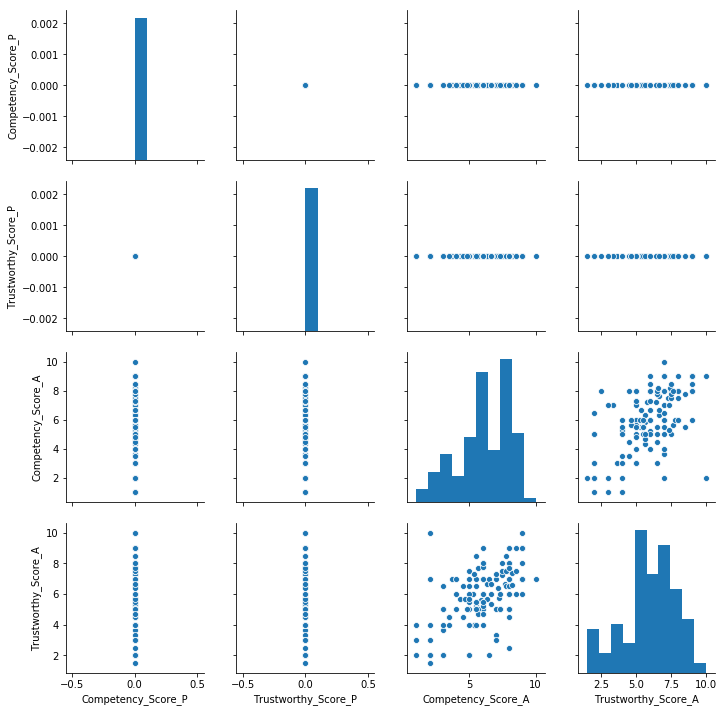

In [5]:
sns.pairplot(df_results)

# Individual Regression - Only on Competency Score

In [6]:
cv_size = 50
x,y = read_and_normalize_train_data(simul = 0)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = create_model(config = 3,output = 1)
for j, (train_idx, val_idx) in enumerate(kfold.split(x,y)): 
    batch_size=50
    print('\nFold ',j)
    X_train_cv = x[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = x[val_idx]
    y_valid_cv= y[val_idx] 
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=5,patience_es = 10)
    gen = imagegen(1)
    STEP_SIZE_TRAIN=len(X_train_cv)//batch_size
    STEP_SIZE_VALID=len(X_valid_cv)//batch_size
    datagen_v = ImageDataGenerator(rescale=1./255)
    gen.fit(X_train_cv)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    generator_v = datagen_v.flow(X_valid_cv, y_valid_cv, batch_size = batch_size)
    model.fit_generator(
                generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data = generator_v,
                validation_steps=STEP_SIZE_VALID,
                callbacks = callbacks)
    print(model.metrics_names)
    print(model.evaluate_generator(generator=generator_v,steps=STEP_SIZE_VALID))

Read train images
Train data shape (800, 3, 128, 85)
Train target shape (800,)
800 train samples

Fold  0
Epoch 1/10
12/12 [==============================] - 63s 5s/step - loss: 3.2895 - mean_absolute_error: 3.2895 - val_loss: 2.6305 - val_mean_absolute_error: 2.6305

Epoch 00001: val_loss improved from inf to 2.63051, saving model to final_model_fold0_weights.h5
Epoch 2/10
12/12 [==============================] - 59s 5s/step - loss: 2.1454 - mean_absolute_error: 2.1454 - val_loss: 1.8132 - val_mean_absolute_error: 1.8132

Epoch 00002: val_loss improved from 2.63051 to 1.81318, saving model to final_model_fold0_weights.h5
Epoch 3/10
12/12 [==============================] - 59s 5s/step - loss: 1.8960 - mean_absolute_error: 1.8960 - val_loss: 1.5839 - val_mean_absolute_error: 1.5839

Epoch 00003: val_loss improved from 1.81318 to 1.58392, saving model to final_model_fold0_weights.h5
Epoch 4/10
12/12 [==============================] - 59s 5s/step - loss: 1.8030 - mean_absolute_error: 1.80


Epoch 00004: val_loss did not improve from 1.44472
Epoch 5/10
12/12 [==============================] - 77s 6s/step - loss: 1.5441 - mean_absolute_error: 1.5441 - val_loss: 1.5553 - val_mean_absolute_error: 1.5553

Epoch 00005: val_loss did not improve from 1.44472
Epoch 6/10
12/12 [==============================] - 75s 6s/step - loss: 1.6156 - mean_absolute_error: 1.6156 - val_loss: 1.5277 - val_mean_absolute_error: 1.5277

Epoch 00006: val_loss did not improve from 1.44472
Epoch 7/10
12/12 [==============================] - 75s 6s/step - loss: 1.5881 - mean_absolute_error: 1.5881 - val_loss: 1.7729 - val_mean_absolute_error: 1.7729

Epoch 00007: val_loss did not improve from 1.44472
Epoch 8/10
12/12 [==============================] - 74s 6s/step - loss: 1.5462 - mean_absolute_error: 1.5462 - val_loss: 1.5000 - val_mean_absolute_error: 1.5000

Epoch 00008: val_loss did not improve from 1.44472
Epoch 9/10
12/12 [==============================] - 77s 6s/step - loss: 1.6920 - mean_absolu

  Image_Name  Competency_Score_P  Competency_Score_A
0   B268.jpg               11.48                3.00
1   B287.jpg               10.62                8.00
2   B467.jpg               13.88                7.67
3   B506.jpg                8.47                5.88
4   B292.jpg               11.64                9.00
MAE Competency: 4.287910435092982


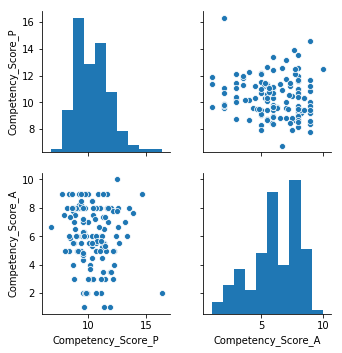

In [7]:
#Unknown Predictions
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,1)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results[['Competency_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Competency_Score_A'] = test_ds['Competency_Score']
df_results = df_results[['Image_Name', 'Competency_Score_P','Competency_Score_A']]
print(df_results.head(5))
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
sns.pairplot(df_results)

# Individual Regression - Only on Trustworthy Score

In [8]:
cv_size = 50
x,y = read_and_normalize_train_data(simul = 1)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = create_model(config = 3,output = 1)
for j, (train_idx, val_idx) in enumerate(kfold.split(x,y)): 
    batch_size=50
    print('\nFold ',j)
    X_train_cv = x[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = x[val_idx]
    y_valid_cv= y[val_idx] 
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=5,patience_es = 10)
    gen = imagegen(1)
    STEP_SIZE_TRAIN=len(X_train_cv)//batch_size
    STEP_SIZE_VALID=len(X_valid_cv)//batch_size
    datagen_v = ImageDataGenerator(rescale=1./255)
    gen.fit(X_train_cv)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    generator_v = datagen_v.flow(X_valid_cv, y_valid_cv, batch_size = batch_size)
    model.fit_generator(
                generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data = generator_v,
                validation_steps=STEP_SIZE_VALID,
                callbacks = callbacks)
    print(model.metrics_names)
    print(model.evaluate_generator(generator=generator_v,steps=STEP_SIZE_VALID))

Read train images
Train data shape (800, 3, 128, 85)
Train target shape (800,)
800 train samples

Fold  0
Epoch 1/10
12/12 [==============================] - 89s 7s/step - loss: 5.5564 - mean_absolute_error: 5.5564 - val_loss: 4.1159 - val_mean_absolute_error: 4.1159

Epoch 00001: val_loss improved from inf to 4.11589, saving model to final_model_fold0_weights.h5
Epoch 2/10
12/12 [==============================] - 83s 7s/step - loss: 2.2909 - mean_absolute_error: 2.2909 - val_loss: 1.4096 - val_mean_absolute_error: 1.4096

Epoch 00002: val_loss improved from 4.11589 to 1.40965, saving model to final_model_fold0_weights.h5
Epoch 3/10
12/12 [==============================] - 76s 6s/step - loss: 1.8815 - mean_absolute_error: 1.8815 - val_loss: 1.4594 - val_mean_absolute_error: 1.4594

Epoch 00003: val_loss did not improve from 1.40965
Epoch 4/10
12/12 [==============================] - 85s 7s/step - loss: 1.8275 - mean_absolute_error: 1.8275 - val_loss: 1.5086 - val_mean_absolute_error: 1

12/12 [==============================] - 77s 6s/step - loss: 1.5892 - mean_absolute_error: 1.5892 - val_loss: 1.3955 - val_mean_absolute_error: 1.3955

Epoch 00004: val_loss did not improve from 1.13262
Epoch 5/10
12/12 [==============================] - 89s 7s/step - loss: 1.5740 - mean_absolute_error: 1.5740 - val_loss: 1.2527 - val_mean_absolute_error: 1.2527

Epoch 00005: val_loss did not improve from 1.13262
Epoch 6/10
12/12 [==============================] - 82s 7s/step - loss: 1.6137 - mean_absolute_error: 1.6137 - val_loss: 1.3476 - val_mean_absolute_error: 1.3476

Epoch 00006: val_loss did not improve from 1.13262
Epoch 7/10
12/12 [==============================] - 77s 6s/step - loss: 1.5470 - mean_absolute_error: 1.5470 - val_loss: 1.3668 - val_mean_absolute_error: 1.3668

Epoch 00007: val_loss did not improve from 1.13262
Epoch 8/10
12/12 [==============================] - 82s 7s/step - loss: 1.5552 - mean_absolute_error: 1.5552 - val_loss: 1.3299 - val_mean_absolute_error: 

  Image_Name  Trustworthy_Score_P  Trustworthy_Score_A
0   B268.jpg                 8.65                 5.00
1   B287.jpg                 8.01                 2.50
2   B467.jpg                 9.20                 6.67
3   B506.jpg                 7.86                 5.62
4   B292.jpg                 9.29                 9.00
MAE Trustworthy: 2.557462675891706


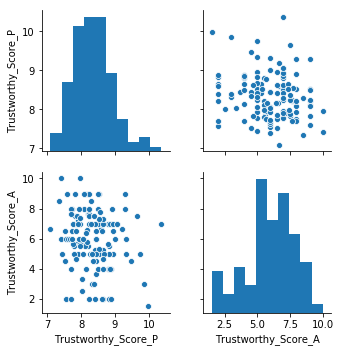

In [9]:
#Unknown Predictions
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,1)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results[['Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)
df_results['Trustworthy_Score_A'] = test_ds['Trustworthy_Score']
df_results = df_results[['Image_Name','Trustworthy_Score_P','Trustworthy_Score_A']]
print(df_results.head(5))
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Trustworthy:", mae_trust)
sns.pairplot(df_results)